**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

import nltk
from sklearn import preprocessing 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics, neighbors
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
%matplotlib inline

import os
os.chdir('../NLP_group')
# from normalization import normalize_corpus

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Reading the Data**

The first label is a bad to good scale 1: Awful 2:Bad 3: Neutral 4:Good 5:Great .

Priority is currently on a scale of 1- 4 with one being the least urgent.

Type of tweet is about content 0: nonsense , 1: personal comments 2: news 3: religious 4: reviews 5: jokes and references 6: clickbait and soft news 7: advertisements 8: personal anecdotes 9: Talk about celeberties, movies ,etc 10: Questions 11: Sports

In [2]:
df = pd.read_csv('../Data/Foreigner Tweets.csv', encoding='latin')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1864 entries, 0 to 1863
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Text      1864 non-null   object 
 1   Good      1864 non-null   int64  
 2   Priority  1861 non-null   float64
 3   Type      733 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 58.4+ KB


In [3]:
df.head()

,Text,Good,Priority,Type
0,*screams in 25 different languages*,3,1.0,5.0
1,Families to sue over Legionnaires: More than 4...,2,2.0,2.0
2,Pandemonium In Aba As Woman Delivers Baby With...,2,1.0,6.0
3,My emotions are a train wreck. My body is a tr...,2,1.0,9.0
4,Alton brown just did a livestream and he burne...,4,1.0,1.0


In [4]:
print(min(df.Good),max(df.Good))

1 5


**Data Cleaning**

In [5]:
# Transform to lower:
df.Text = df.Text.str.lower()
#Remove urls:
df.Text = df.Text.str.replace('http\S+|www.\S+', '', case=False)
#Remove hashtag character
df.Text = df.Text.str.replace('#', '', case=False)
# Remove punctuation, special characters & mentions:
df.Text = df.Text.str.replace(r'[^\w\s]', '', case=False)
# #Remove stopwords:
stop_words = set(stopwords.words('english'))
df.Text = df.Text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
#Remove non alphabetic words:
df.Text = df.Text.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
#Remove emptys rows:
df = df[df.Text != '']
#Initiate a lemmatizer and lemmatize each word in the data
lemmatizer = WordNetLemmatizer()
df.Text = df.Text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


Let's check if the cleaning seems okay:

In [6]:
for i in range(0,5):
    print(i,':',df.Text[i])   

0 : scream different language
1 : family sue legionnaire family affected fatal outbreak legionnaire disea
2 : pandemonium aba woman delivers baby without face photo
3 : emotion train wreck body train wreck im wreck
4 : alton brown livestream burned butter touched hot plate soon made nut joke


In [7]:
df.head()

,Text,Good,Priority,Type
0,scream different language,3,1.0,5.0
1,family sue legionnaire family affected fatal o...,2,2.0,2.0
2,pandemonium aba woman delivers baby without fa...,2,1.0,6.0
3,emotion train wreck body train wreck im wreck,2,1.0,9.0
4,alton brown livestream burned butter touched h...,4,1.0,1.0


Text(0.5, 1.0, 'Before sampling')

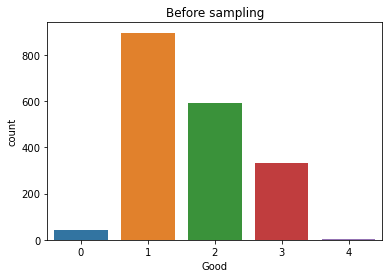

In [8]:
# Encode labels in column 'category'.
label_encoder = preprocessing.LabelEncoder() 
df['Good']= label_encoder.fit_transform(df['Good']) 

sns.countplot(df.Good)
plt.xlabel('Good')
plt.ylabel('count')
plt.title('Before sampling')

In [9]:
print(df.Good)

0       2
1       1
2       1
3       1
4       3
       ..
1859    3
1860    2
1861    2
1862    1
1863    1
Name: Good, Length: 1864, dtype: int64


Text(0.5, 1.0, 'After sampling')

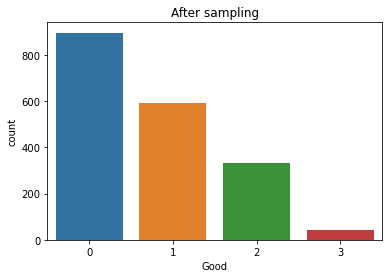

In [10]:
#Sampling the data

df0 = df[df.Good==0]
df1 = df[df.Good==1]
df2 = df[df.Good==2]
df3 = df[df.Good==3]

samples = df.Good.value_counts().tolist()



df0 = resample(df0, 
                   replace=True,   
                   n_samples=samples[0], 
                   random_state=1130)
df1 = resample(df1, 
                   replace=True,    
                   n_samples=samples[1],
                   random_state=123)
df2 = resample(df2, 
                   replace=True,    
                   n_samples=samples[2],
                   random_state=123)
df3 = resample(df3, 
                   replace=True,    
                   n_samples=samples[3],
                   random_state=123)


df_sampled = pd.concat([df0,df1,df2,df3])

df= df_sampled



sns.countplot(df_sampled.Good)
plt.xlabel('Good')
plt.ylabel('count')
plt.title('After sampling')

**Feature Extraction using Bag of words**

In [11]:
training_set, test_set, training_labels, test_labels = train_test_split(df["Text"], df["Good"], test_size=0.2, random_state=42)

In [12]:
training_set.shape, test_set.shape, training_labels.shape, test_labels.shape

((1489,), (373,), (1489,), (373,))

**BAG OF WORDS**

In [13]:
#Bag of words
vectorizer = CountVectorizer(min_df =2, ngram_range=(2,2))
bow_train_features = vectorizer.fit_transform(training_set)
bow_test_features = vectorizer.transform(test_set)

**Classification using Bag of words features**

**LOGISTIC REGRESSION**

Logistic Regression using Bag of words

Accuracy:  83.10991957104558 

Classification Report

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       188
           1       0.64      0.99      0.77       109
           2       1.00      0.22      0.36        63
           3       0.00      0.00      0.00        13

    accuracy                           0.83       373
   macro avg       0.66      0.55      0.53       373
weighted avg       0.86      0.83      0.79       373



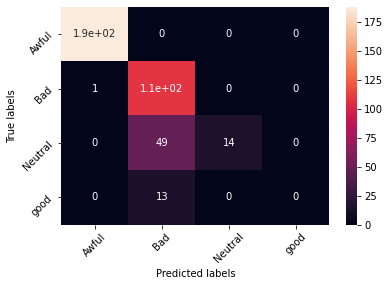

In [14]:
#Logistic Regression

logRegModel = LogisticRegression()
logRegModel.fit(bow_train_features,training_labels)

predictions_lr = logRegModel.predict(bow_test_features)

print("Logistic Regression using Bag of words\n")
accrcy = accuracy_score(predictions_lr, test_labels)*100
print("Accuracy: ",accuracy_score(predictions_lr, test_labels)*100,"\n")

print("Classification Report\n")
print(classification_report(test_labels,predictions_lr))

#Plotting the confusion matrix
cm = confusion_matrix(test_labels, predictions_lr)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Awful', 'Bad','Neutral','good'],rotation =45); 
ax.yaxis.set_ticklabels(['Awful', 'Bad','Neutral','good'],rotation =45);


In [15]:
#store the model results for each model data frame for final comparison
results_temp = pd.DataFrame({'Method':['Logistic Regression'],'Accuracy':accrcy},index={'1'})
# results = pd.concat([results,results_temp])
results = results_temp[['Method','Accuracy']]

results

,Method,Accuracy
1,Logistic Regression,83.10992


**NAIVE BAYES (NB)**

MultiNomial Naive Bayes using Bag of words

Accuracy:  61.3941018766756 

Classification Report

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       188
           1       0.83      0.23      0.36       109
           2       0.89      0.25      0.40        63
           3       0.00      0.00      0.00        13

    accuracy                           0.61       373
   macro avg       0.58      0.37      0.37       373
weighted avg       0.69      0.61      0.54       373



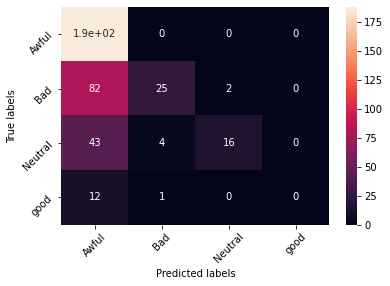

In [16]:
#Naive Bayes
mnb = MultinomialNB()
mnb.fit(bow_train_features,training_labels)

predictions_mnb = mnb.predict(bow_test_features)

print("MultiNomial Naive Bayes using Bag of words\n")
accrcy = accuracy_score(predictions_mnb, test_labels)*100
print("Accuracy: ",accuracy_score(predictions_mnb, test_labels)*100,"\n")

print("Classification Report\n")
print(classification_report(test_labels,predictions_mnb))


#Plotting the confusion matrix
cm = confusion_matrix(test_labels, predictions_mnb)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Awful', 'Bad','Neutral','good'],rotation =45); 
ax.yaxis.set_ticklabels(['Awful', 'Bad','Neutral','good'],rotation =45);

In [17]:
#store the model results for each model data frame for final comparison
results_temp = pd.DataFrame({'Method':['Naive Bayes'],'Accuracy':accrcy},index={'2'})
results = pd.concat([results,results_temp])
results = results[['Method','Accuracy']]

results

,Method,Accuracy
1,Logistic Regression,83.109920
2,Naive Bayes,61.394102


**RANDOM FOREST (RF)**

Random Forest using Bag of words

Accuracy:  83.10991957104558 

Classification Report

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       188
           1       0.64      0.98      0.77       109
           2       0.94      0.24      0.38        63
           3       0.00      0.00      0.00        13

    accuracy                           0.83       373
   macro avg       0.64      0.55      0.54       373
weighted avg       0.85      0.83      0.79       373



<Figure size 432x288 with 0 Axes>

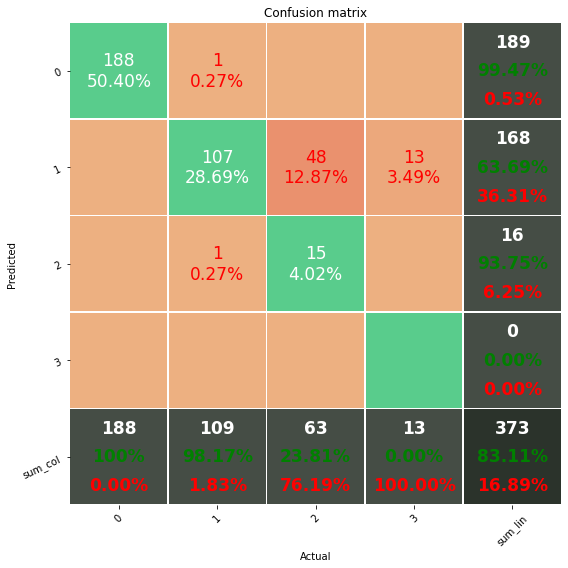

In [18]:
#Random Forest
rfc = RandomForestClassifier(n_estimators=5)
rfc.fit(bow_train_features,training_labels)

predictions_rfc = rfc.predict(bow_test_features)

print("Random Forest using Bag of words\n")
accrcy = accuracy_score(predictions_rfc, test_labels)*100
print("Accuracy: ",accuracy_score(predictions_rfc, test_labels)*100,"\n")

print("Classification Report\n")
print(classification_report(test_labels,predictions_rfc))


#Plotting the confusion matrix
cm = confusion_matrix(test_labels, predictions_rfc)
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

#different way expressing the confusion matrix plot
%run -i '/Users/preethamvignesh/Desktop/Work/ML_EIT/Github/confusion_matrix_different_ways.py'
df_confmatrx = pd.DataFrame(cm, range(4),range(4))
df_confmatrx
cmap = 'flare'
confusion_matrix_dfrntway(df_confmatrx, cmap=cmap,fz=17)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Awful', 'Bad','Neutral','good'],rotation =45); 
ax.yaxis.set_ticklabels(['Awful', 'Bad','Neutral','good'],rotation =45);

In [19]:
#store the model results for each model data frame for final comparison
results_temp = pd.DataFrame({'Method':['Random Forest'],'Accuracy':accrcy},index={'3'})
results = pd.concat([results,results_temp])
results = results[['Method','Accuracy']]

results

,Method,Accuracy
1,Logistic Regression,83.109920
2,Naive Bayes,61.394102
3,Random Forest,83.109920


**SUPPORT VECTOR MACHINES (SVM)**

Support Vector Machine using Bag of words

Test data Accuracy:  82.84182305630027 

Classification Report

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       188
           1       0.63      0.99      0.77       109
           2       1.00      0.21      0.34        63
           3       0.00      0.00      0.00        13

    accuracy                           0.83       373
   macro avg       0.66      0.55      0.53       373
weighted avg       0.85      0.83      0.79       373



<Figure size 432x288 with 0 Axes>

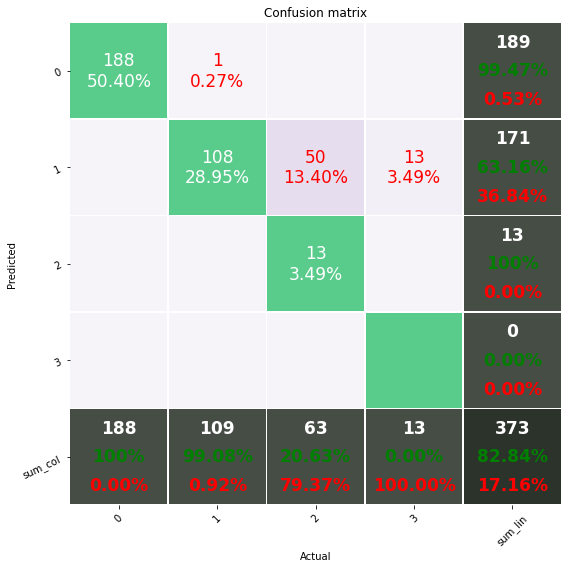

In [20]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(bow_train_features,training_labels)

#For predictions for testing set
predictions_SVM = SVM.predict(bow_test_features)

#Calculate testing accuracy
print("Support Vector Machine using Bag of words\n")
accrcy = accuracy_score(predictions_SVM, test_labels)*100
print("Test data Accuracy: ",accuracy_score(predictions_SVM, test_labels)*100,"\n")

print("Classification Report\n")
print(classification_report(test_labels,predictions_SVM))

#Plotting the confusion matrix
cm = confusion_matrix(test_labels, predictions_SVM)
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

#different way expressing the confusion matrix plot
%run -i '/Users/preethamvignesh/Desktop/Work/ML_EIT/Github/confusion_matrix_different_ways.py'
df_confmatrx = pd.DataFrame(cm, range(4),range(4))
df_confmatrx
cmap = 'PuRd'
confusion_matrix_dfrntway(df_confmatrx, cmap=cmap,fz=17)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Awful', 'Bad','Neutral','good'],rotation =45); 
ax.yaxis.set_ticklabels(['Awful', 'Bad','Neutral','good'],rotation =45);

In [21]:
#store the model results for each model data frame for final comparison
results_temp = pd.DataFrame({'Method':['Support Vector Machine'],'Accuracy':accrcy},index={'4'})
results = pd.concat([results,results_temp])
results = results[['Method','Accuracy']]

results

,Method,Accuracy
1,Logistic Regression,83.109920
2,Naive Bayes,61.394102
3,Random Forest,83.109920
4,Support Vector Machine,82.841823


In [22]:
# #GradientBoostingRegressor
# gbr = GradientBoostingRegressor()
# gbr.fit(bow_train_features,training_labels)

# #For predictions for testing set
# predictions_gbr = gbr.predict(bow_test_features)

# from numpy import mean
# from numpy import std
# # predictions_gbr
# # test_labels.unique()
# # print('MAE: %.3f (%.3f)' % (mean(predictions_gbr), std(predictions_gbr)))
# # #Calculate testing accuracy
# # print("Support Vector Machine using Bag of words\n")
# # accrcy = accuracy_score(predictions_gbr, test_labels)*100
# # print("Test data Accuracy: ",accuracy_score(predictions_gbr, test_labels)*100,"\n")


In [23]:
# plt.figure()
# plt.scatter(bow_train_features[:,0],bow_train_features[:,1], c=training_labels, alpha=0.25)
bow_train_features.shape,training_labels.shape

((1489, 1411), (1489,))

In [24]:
trial = bow_train_features[:,0]
trial.shape

(1489, 1)